<a href="https://colab.research.google.com/github/AnhVietPham/Deep-Learning/blob/main/DLTensorflow/multilayer-perceptrons/Predicting_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install d2l==0.17.0

In [31]:
import hashlib
import os 
import tarfile
import zipfile
import requests
from IPython.display import display

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [5]:
def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [6]:
def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [7]:
def download_all():
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

In [6]:
!pip install pandas==1.1.1

      Successfully uninstalled pandas-1.1.5


In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from d2l import tensorflow as d2l

In [9]:
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [10]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [11]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [12]:
print(train_data.iloc[:, 1:])

      MSSubClass MSZoning  LotFrontage  ...  SaleType SaleCondition SalePrice
0             60       RL         65.0  ...        WD        Normal    208500
1             20       RL         80.0  ...        WD        Normal    181500
2             60       RL         68.0  ...        WD        Normal    223500
3             70       RL         60.0  ...        WD       Abnorml    140000
4             60       RL         84.0  ...        WD        Normal    250000
...          ...      ...          ...  ...       ...           ...       ...
1455          60       RL         62.0  ...        WD        Normal    175000
1456          20       RL         85.0  ...        WD        Normal    210000
1457          70       RL         66.0  ...        WD        Normal    266500
1458          20       RL         68.0  ...        WD        Normal    142125
1459          20       RL         75.0  ...        WD        Normal    147500

[1460 rows x 80 columns]


In [13]:
print(test_data.iloc[:, 1:])

      MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType SaleCondition
0             20       RH         80.0  ...    2010       WD        Normal
1             20       RL         81.0  ...    2010       WD        Normal
2             60       RL         74.0  ...    2010       WD        Normal
3             60       RL         78.0  ...    2010       WD        Normal
4            120       RL         43.0  ...    2010       WD        Normal
...          ...      ...          ...  ...     ...      ...           ...
1454         160       RM         21.0  ...    2006       WD        Normal
1455         160       RM         21.0  ...    2006       WD       Abnorml
1456          20       RL        160.0  ...    2006       WD       Abnorml
1457          85       RL         62.0  ...    2006       WD        Normal
1458          60       RL         74.0  ...    2006       WD        Normal

[1459 rows x 79 columns]


In [14]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [15]:
print(all_features)

      MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType SaleCondition
0             60       RL         65.0  ...    2008       WD        Normal
1             20       RL         80.0  ...    2007       WD        Normal
2             60       RL         68.0  ...    2008       WD        Normal
3             70       RL         60.0  ...    2006       WD       Abnorml
4             60       RL         84.0  ...    2008       WD        Normal
...          ...      ...          ...  ...     ...      ...           ...
1454         160       RM         21.0  ...    2006       WD        Normal
1455         160       RM         21.0  ...    2006       WD       Abnorml
1456          20       RL        160.0  ...    2006       WD       Abnorml
1457          85       RL         62.0  ...    2006       WD        Normal
1458          60       RL         74.0  ...    2006       WD        Normal

[2919 rows x 79 columns]


# **Data Preprocessing**

In [18]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [19]:
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x-x.mean()) / (x.std()))

In [20]:
print(all_features)

      MSSubClass MSZoning  LotFrontage  ...    YrSold SaleType SaleCondition
0       0.067320       RL    -0.184443  ...  0.157619       WD        Normal
1      -0.873466       RL     0.458096  ... -0.602858       WD        Normal
2       0.067320       RL    -0.055935  ...  0.157619       WD        Normal
3       0.302516       RL    -0.398622  ... -1.363335       WD       Abnorml
4       0.067320       RL     0.629439  ...  0.157619       WD        Normal
...          ...      ...          ...  ...       ...      ...           ...
1454    2.419286       RM    -2.069222  ... -1.363335       WD        Normal
1455    2.419286       RM    -2.069222  ... -1.363335       WD       Abnorml
1456   -0.873466       RL     3.884968  ... -1.363335       WD       Abnorml
1457    0.655311       RL    -0.312950  ... -1.363335       WD        Normal
1458    0.067320       RL     0.201080  ... -1.363335       WD        Normal

[2919 rows x 79 columns]


In [21]:
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [22]:
all_features = pd.get_dummies(all_features, dummy_na=True)

In [23]:
print(all_features)

      MSSubClass  LotFrontage  ...  SaleCondition_Partial  SaleCondition_nan
0       0.067320    -0.184443  ...                      0                  0
1      -0.873466     0.458096  ...                      0                  0
2       0.067320    -0.055935  ...                      0                  0
3       0.302516    -0.398622  ...                      0                  0
4       0.067320     0.629439  ...                      0                  0
...          ...          ...  ...                    ...                ...
1454    2.419286    -2.069222  ...                      0                  0
1455    2.419286    -2.069222  ...                      0                  0
1456   -0.873466     3.884968  ...                      0                  0
1457    0.655311    -0.312950  ...                      0                  0
1458    0.067320     0.201080  ...                      0                  0

[2919 rows x 331 columns]


In [32]:
display(all_features)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PavedDrive_nan,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,-0.934542,-0.444176,-0.773728,1.207172,-0.10118,0.413476,1.086464,-0.249767,0.781232,1.232388,0.169898,-0.207663,0.986680,-0.924153,0.973110,0.306423,0.348780,-0.740634,0.199972,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,0.157619,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,-0.629681,0.476948,0.261030,-0.784891,-0.10118,-0.471810,-0.819258,3.820454,0.781232,-0.756191,0.169898,-0.207663,-0.287709,0.623525,-0.082638,0.306423,-0.059772,1.614603,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.446848,-0.602858,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,-0.288418,-0.298974,-0.610614,1.235163,-0.10118,0.563659,1.086464,-0.249767,0.781232,1.232388,0.169898,-0.207663,-0.287709,0.623525,0.894907,0.306423,0.627338,-0.740634,-0.081195,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,0.157619,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,-0.047258,-0.671053,-0.506118,0.978574,-0.10118,0.427309,1.086464,-0.249767,-1.027187,-0.756191,0.169898,-0.207663,0.349486,0.623525,0.777601,1.619406,0.785188,-0.740634,-0.184783,3.874303,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,-1.363335,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,-0.161013,0.211501,-0.037164,1.671364,-0.10118,1.377806,1.086464,-0.249767,0.781232,1.232388,1.385418,-0.207663,1.623875,0.623525,0.855805,1.619406,1.685860,0.776834,0.540332,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,2.131647,0.157619,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,-0.033608,-1.147496,-1.563815,0.488723,-0.10118,-0.807744,-0.819258,-0.249767,-1.027187,1.232388,0.169898,-0.207663,-0.924904,-0.924153,0.000000,-2.319544,-2.195385,-0.740634,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.078492,-1.363335,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1455,2.419

In [34]:
n_train = train_data.shape[0]
n_train

1460

In [49]:
first_column = all_features.iloc[:, 0]
print(first_column)

0       0.067320
1      -0.873466
2       0.067320
3       0.302516
4       0.067320
          ...   
1454    2.419286
1455    2.419286
1456   -0.873466
1457    0.655311
1458    0.067320
Name: MSSubClass, Length: 2919, dtype: float64


In [35]:
train_features = tf.constant(all_features[:n_train].values, dtype=tf.float32)
train_features

<tf.Tensor: shape=(1460, 331), dtype=float32, numpy=
array([[ 0.06731988, -0.18444261, -0.21784137, ...,  1.        ,
         0.        ,  0.        ],
       [-0.8734664 ,  0.45809588, -0.07203174, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.06731988, -0.05593492,  0.13717337, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.30251643, -0.14160672, -0.14278111, ...,  1.        ,
         0.        ,  0.        ],
       [-0.8734664 , -0.05593492, -0.0571972 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.8734664 ,  0.24391638, -0.02930318, ...,  1.        ,
         0.        ,  0.        ]], dtype=float32)>

In [50]:
test_features = tf.constant(all_features[n_train:].values, dtype = tf.float32)
test_features

<tf.Tensor: shape=(1459, 331), dtype=float32, numpy=
array([[-0.8734664 ,  0.45809588,  0.18433963, ...,  1.        ,
         0.        ,  0.        ],
       [-0.8734664 ,  0.5009318 ,  0.5197018 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.06731988,  0.20108049,  0.4642941 , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.8734664 ,  3.8849678 ,  1.2465944 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.6553113 , -0.3129503 ,  0.03459947, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.06731988,  0.20108049, -0.06860839, ...,  1.        ,
         0.        ,  0.        ]], dtype=float32)>

In [51]:
train_labels = tf.constant(
    train_data.SalePrice.values.reshape(-1,1), dtype = tf.float32
)
train_labels

<tf.Tensor: shape=(1460, 1), dtype=float32, numpy=
array([[208500.],
       [181500.],
       [223500.],
       ...,
       [266500.],
       [142125.],
       [147500.]], dtype=float32)>

# **Training**

In [63]:
loss = tf.keras.losses.MeanSquaredError()

def get_net():
  net = tf.keras.models.Sequential()
  net.add(tf.keras.layers.Dense(
      1, kernel_regularizer = tf.keras.regularizers.l2(weight_decay)
  ))
  return net

In [62]:
def log_rmse(y_true, y_pred):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = tf.clip_by_value(y_pred, 1, float('inf'))
    return tf.sqrt(tf.reduce_mean(loss(
        tf.math.log(y_true), tf.math.log(clipped_preds))))

In [64]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
  train_ls, test_ls = [],[]
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  optimizer = tf.keras.optimizers.Adam(learning_rate)
  net.compile(loss= loss, optimizer=optimizer)
  for epoch in range(num_epochs):
    for X, y in train_iter:
      with tf.GradientTape() as tape:
        y_hat = net(X)
        l = loss(y, y_hat)
      params = net.trainable_variables
      grads = tape.gradient(l, params)
      optimizer.apply_gradients(zip(grads, params))
    train_ls.append(log_rmse(train_labels, net(train_features)))
    if test_labels is not None:
      test_ls.append(log_rmse(test_labels, net(test_features)))
  return train_ls, test_ls

In [65]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], 0)
            y_train = tf.concat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [66]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.169723, valid log rmse 0.156342
fold 2, train log rmse 0.162533, valid log rmse 0.189657
fold 3, train log rmse 0.163879, valid log rmse 0.168541
fold 4, train log rmse 0.168376, valid log rmse 0.154778
fold 5, train log rmse 0.162229, valid log rmse 0.182367
5-fold validation: avg train log rmse: 0.165348, avg valid log rmse: 0.170337


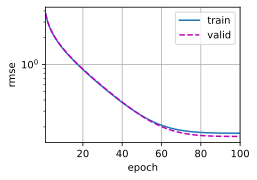

In [67]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')